# Project : Skimlit

The purpose of thi notebook is to create a NLP model to make reading medical abstract easier.



## Get data

Since we are creating a NLP model , we'll be replecating the paper of **Padmed 200k RCT**, let's download the dataset that they used  

In [1]:
!wget https://raw.githubusercontent.com/PJ-BN/Helper-module/main/helperfunc.py


--2023-01-26 04:02:36--  https://raw.githubusercontent.com/PJ-BN/Helper-module/main/helperfunc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10449 (10K) [text/plain]
Saving to: ‘helperfunc.py’

helperfunc.py       100%[===================>]  10.20K  --.-KB/s    in 0s      

2023-01-26 04:02:36 (97.0 MB/s) - ‘helperfunc.py’ saved [10449/10449]



In [2]:
from helperfunc import unzip_data

In [10]:
unzip_data("PubMed_20k_RCT_numbers_replaced_with_at_sign.zip")

In [11]:
DATA_DIR = "PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [12]:
def get_file(filenames):
    """
    This function is used to return all the text contain in the file as a list 
    
    filenames : name of the file to read
    
    returns a list of text as a string
    """
    with open(DATA_DIR+filenames, 'r') as f:
        return f.readlines()


In [13]:
def preprocess_the_data(filenames):
    """
    This function helps the text file to be stored in a specific order like
    [{
        'target': target,
        'text' : text,
        'line_number': line_number,
        'total_line': total_line
    }]
    
    and store all the above dictory in a list
    """
    
    get_lines = get_file(filenames)
    
    abstract_sample = []
    abstract_line = ""
    
    for line in get_lines:
        if line.startswith("###"):
            abstract_line = ""
            
            
        elif line.isspace():
            
            abstract_line_split = abstract_line.splitlines()
        
            for line_number, line_d in enumerate(abstract_line_split):
                line_data = {}
                abstract_text_target_split = line_d.split('\t')
                line_data["target"] = abstract_text_target_split[0]
                line_data["text"] = abstract_text_target_split[1].lower()
                line_data["line_number"] = line_number
                line_data["total_line"] = len(abstract_line_split)-1
                
                abstract_sample.append(line_data)
            
        
        else:
            abstract_line += line
            
    return abstract_sample

In [14]:
train_data = preprocess_the_data("train.txt")
val_data = preprocess_the_data("dev.txt")
test_data = preprocess_the_data("test.txt")
train_data[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontario an

In [15]:
import pandas as pd

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

train_df.head()

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [17]:
train_sentences = train_df["text"]
val_sentences = val_df["text"]
test_sentences = test_df["text"]

train_sentences[:10]

0    to investigate the efficacy of @ weeks of dail...
1    a total of @ patients with primary knee oa wer...
2    outcome measures included pain reduction and i...
3    pain was assessed using the visual analog pain...
4    secondary outcome measures included the wester...
5    serum levels of interleukin @ ( il-@ ) , il-@ ...
6    there was a clinically relevant reduction in t...
7    the mean difference between treatment arms ( @...
8    further , there was a clinically relevant redu...
9    these differences remained significant at @ we...
Name: text, dtype: object

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_label_encoded = label_encoder.fit_transform(train_df["target"])
val_label_encoded = label_encoder.transform(val_df["target"])
test_label_encoded = label_encoder.transform(test_df["target"])

label_length = len(label_encoder.classes_)
label_class = label_encoder.classes_

train_label_encoded, label_length, label_class

(array([3, 2, 2, ..., 4, 1, 1]),
 5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

max_vocab = 68000
text_vector = layers.TextVectorization(max_tokens = max_vocab,
                                      output_sequence_length = 55)
embedding = layers.Embedding(max_vocab, 
                            128,
                            mask_zero = True)

text_vector.adapt(train_sentences)

# Creating a baseline model using Naive Bayes

 Here we are using a model of sciket learn called Naive Bayes to create a baseline model for us
 

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])


model_0.fit(train_sentences, train_label_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(val_sentences, val_label_encoded)

0.7218323844829869

In [22]:
from helperfunc import calculate_results


In [23]:

baseline_preds = model_0.predict(val_sentences)

In [24]:
baseline_results =calculate_results(val_label_encoded, baseline_preds)

In [25]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [26]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

train_one_hot = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_one_hot = ohe.transform(val_df["target"].to_numpy().reshape(-1,1))
test_one_hot = ohe.transform(test_df["target"].to_numpy().reshape(-1,1))

train_one_hot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [27]:
train_datasets = tf.data.Dataset.from_tensor_slices((train_sentences, train_one_hot))
val_datasets = tf.data.Dataset.from_tensor_slices((val_sentences, val_one_hot))
test_datasets = tf.data.Dataset.from_tensor_slices((test_sentences, test_one_hot))

train_datasets

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [28]:
train_datasets = train_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
val_datasets = val_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
test_datasets = test_datasets.batch(32).prefetch(tf.data.AUTOTUNE)



In [29]:
train_datasets

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Creating our first deep learning model  

## Using Convulation method(CNN)

In [30]:
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vector(inputs)
x = embedding(x)
x = layers.Conv1D(64,2, activation ="tanh")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation = "tanh")(x)
outputs = layers.Dense(label_length, activation = "softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)


In [31]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 54, 64)            16448     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                4160  

In [32]:
model_1.compile(loss = "categorical_crossentropy",
               optimizer = "adam",
               metrics =["accuracy"])

model_1_history = model_1.fit(train_datasets,
                              epochs = 5, 
                             steps_per_epoch=0.1*len(train_datasets),
                             validation_data = val_datasets,
                             validation_steps=0.1*len(val_datasets))

Epoch 1/5
562/562 [==============================] - 14s 9ms/step - loss: 0.9082 - accuracy: 0.6273 - val_loss: 0.6938 - val_accuracy: 0.7164
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6784 - accuracy: 0.7393 - val_loss: 0.6455 - val_accuracy: 0.7599
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6471 - accuracy: 0.7561 - val_loss: 0.6181 - val_accuracy: 0.7599
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6144 - accuracy: 0.7745 - val_loss: 0.6060 - val_accuracy: 0.7691
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6172 - accuracy: 0.7768 - val_loss: 0.5869 - val_accuracy: 0.7878


In [33]:
model_1.evaluate(val_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.5942 - accuracy: 0.7867


[0.5941609740257263, 0.7867403626441956]

In [34]:
model_1_preds = model_1.predict(val_datasets)

945/945 [==============================] - 2s 2ms/step


In [35]:
model_1_preds, model_1_preds.shape

(array([[5.7014620e-01, 1.9554156e-01, 3.8818233e-02, 1.6205838e-01,
         3.3435624e-02],
        [5.0497383e-01, 2.7526551e-01, 6.3875904e-03, 2.0028375e-01,
         1.3089296e-02],
        [2.0877802e-01, 1.6096620e-02, 2.0573051e-03, 7.7301949e-01,
         4.8624821e-05],
        ...,
        [5.3319152e-05, 1.6090714e-03, 5.4657995e-03, 6.2828192e-05,
         9.9280894e-01],
        [1.9766615e-01, 2.8092429e-01, 9.9583291e-02, 9.0974033e-02,
         3.3085221e-01],
        [3.0058706e-01, 6.1718613e-01, 3.6721032e-02, 2.8198173e-02,
         1.7307634e-02]], dtype=float32), (30212, 5))

In [36]:
model_1_preds = tf.argmax(model_1_preds, 1)

In [37]:
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [38]:
model_1_results = calculate_results(val_label_encoded, model_1_preds)
model_1_results

{'accuracy': 78.67403680656693,
 'precision': 0.7942271417716452,
 'recall': 0.7867403680656693,
 'f1': 0.7878080679181818}

In [39]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Using tensorflow hub(pretrained embedding layers)

In [40]:
import tensorflow_hub as hub

tf_hub_embedding_layers = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable= False,
                                        name="unversal_sentence_encoder")



In [41]:
inputs = layers.Input(shape = [] , dtype = "string")
x = tf_hub_embedding_layers(inputs)
x = layers.Dense(128, activation ="tanh")(x)
outputs = layers.Dense(label_length, activation = "softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss = "categorical_crossentropy",
               optimizer = "adam",
               metrics = ["accuracy"])

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 unversal_sentence_encoder (  (None, 512)              256797824 
 KerasLayer)                                                     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [42]:
model_2_history = model_2.fit(train_datasets,
                             steps_per_epoch=0.1*len(train_datasets),
                             validation_data = val_datasets,
                             validation_steps = 0.1*len(val_datasets),
                             epochs = 5)

Epoch 1/5
562/562 [==============================] - 13s 15ms/step - loss: 0.9027 - accuracy: 0.6569 - val_loss: 0.8119 - val_accuracy: 0.6819
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7844 - accuracy: 0.6959 - val_loss: 0.7837 - val_accuracy: 0.6967
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7846 - accuracy: 0.7000 - val_loss: 0.7839 - val_accuracy: 0.6987
Epoch 4/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7662 - accuracy: 0.7044 - val_loss: 0.7718 - val_accuracy: 0.7043
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7883 - accuracy: 0.6973 - val_loss: 0.7684 - val_accuracy: 0.7020


In [43]:
model_2.evaluate(val_datasets)

945/945 [==============================] - 11s 12ms/step - loss: 0.7644 - accuracy: 0.7081


[0.7644494771957397, 0.7080961465835571]

In [44]:
model_2_preds = model_2.predict(val_datasets)

model_2_preds = tf.argmax(model_2_preds, 1)

model_2_results = calculate_results(val_label_encoded, model_2_preds)

945/945 [==============================] - 13s 13ms/step


In [45]:
model_2_results

{'accuracy': 70.80961207467232,
 'precision': 0.7050697148153601,
 'recall': 0.7080961207467231,
 'f1': 0.7026110036554245}

Till now we have created all the model using Token embedding but from now on we will use character level embedding to make new models

## Creating character level datasets

Now we will change our datasets to character level 

In [46]:
train_char = [" ".join(list(sentence))  for sentence in train_sentences]
val_char = [" ".join(list(sentence)) for sentence in val_sentences]
test_char = [" ".join(list(sentence)) for sentence in test_sentences]

In [47]:
train_char[:10]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [48]:
train_char_datasets = tf.data.Dataset.from_tensor_slices((train_char, train_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_datasets = tf.data.Dataset.from_tensor_slices((val_char, val_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_datasets = tf.data.Dataset.from_tensor_slices((test_char, test_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [49]:
train_char_datasets

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [50]:
import string

alpha_length = string.ascii_lowercase + string.digits + string.punctuation
alpha_length , len(alpha_length)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [51]:
char_vector = layers.TextVectorization(len(alpha_length)+2, output_sequence_length=290)

char_embed = layers.Embedding(len(alpha_length)+2 , 128, mask_zero= True)

char_vector.adapt(train_char)

## Createing a Convulational model using character embedding

In [52]:
inputs = layers.Input(shape = (1,), dtype = "string")
x = char_vector(inputs)
x = char_embed(x)
x = layers.Conv1D(64, 5, activation= "tanh")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation = "tanh")(x)
outputs = layers.Dense(label_length , activation = "softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss = "categorical_crossentropy",
               optimizer = "adam",
               metrics = ["accuracy"])

model_3.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fbfddef3e80>>

In [53]:
model_3_history = model_3.fit(train_char_datasets,
                             epochs = 5,
                             validation_data = val_char_datasets,
                             steps_per_epoch = 0.1*len(train_char_datasets),
                             validation_steps = 0.1*len(val_char_datasets))

Epoch 1/5
562/562 [==============================] - 5s 7ms/step - loss: 1.1180 - accuracy: 0.5422 - val_loss: 0.9461 - val_accuracy: 0.6125
Epoch 2/5
562/562 [==============================] - 4s 6ms/step - loss: 0.9011 - accuracy: 0.6404 - val_loss: 0.8465 - val_accuracy: 0.6750
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.8505 - accuracy: 0.6644 - val_loss: 0.8133 - val_accuracy: 0.6836
Epoch 4/5
562/562 [==============================] - 4s 6ms/step - loss: 0.8121 - accuracy: 0.6844 - val_loss: 0.8474 - val_accuracy: 0.6684
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8050 - accuracy: 0.6906 - val_loss: 0.7643 - val_accuracy: 0.7049


In [54]:
model_3.evaluate(val_char_datasets)

945/945 [==============================] - 4s 4ms/step - loss: 0.7752 - accuracy: 0.7012


[0.7751944065093994, 0.7011783123016357]

In [55]:
model_3_preds = model_3.predict(val_char_datasets)

model_3_preds = tf.argmax(model_3_preds, 1)
model_3_results = calculate_results(val_label_encoded, model_3_preds)

945/945 [==============================] - 3s 3ms/step


In [56]:
model_3_results

{'accuracy': 70.11783397325566,
 'precision': 0.7007768030079576,
 'recall': 0.7011783397325566,
 'f1': 0.6953356476126269}

Now we will create a multimodel concatenating token level model and char level model
Steps we will follow here are 
- Create a token level model
- Create a char level model
- Concatenate both the model and create another model
- Use Dropout and create output layers and built final model

In [57]:
# Creating token-input model
token_input = layers.Input(shape = [], dtype = tf.string)
token_embedding = tf_hub_embedding_layers(token_input)
token_dense_layer = layers.Dense(128, activation = "relu")(token_embedding)
token_output = layers.Dense(128, activation = "relu")(token_dense_layer)

token_model = tf.keras.Model(token_input , token_output , name = "Token_model")

# Creating char-input Model
char_input = layers.Input(shape= (1,), dtype = tf.string)
char_vectorizer = char_vector(char_input)
char_embedding = char_embed(char_vectorizer)
bi_layer = layers.Bidirectional(layers.LSTM(24), name = "Bidirectional_layer")(char_embedding)
char_output = layers.Dense(128, activation = "relu", name = "Char_output_layer")(bi_layer)

char_model = tf.keras.Model(char_input , char_output, name = "char_model")

# Concatenating two models

concat_layers = layers.concatenate([token_model.output, char_model.output])

# Creating some dropout

dropout_layers = layers.Dropout(0.5)(concat_layers)

final_dense_layers = layers.Dense(128, activation = "relu")(dropout_layers)

dropout_layers = layers.Dropout(0.5)(final_dense_layers)

output_layers = layers.Dense(label_length, activation = "softmax")(dropout_layers)

token_char_model = tf.keras.Model((token_model.input, char_model.input), output_layers)



In [58]:
token_char_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 unversal_sentence_encoder (Ker  (None, 512)         256797824   ['input_4[0][0]']          

In [59]:
token_char_model.compile(loss = "categorical_crossentropy",
                        optimizer = "adam",
                        metrics = ["accuracy"])

In [60]:
# Creating the training and validation datasets for token_char_model

def transform(t_data, c_data, labels):
    x = tf.data.Dataset.from_tensor_slices((t_data, c_data))
    y = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((x,y)).batch(32).prefetch(tf.data.AUTOTUNE)

In [61]:
token_train_dataset = transform(train_sentences, train_char, train_one_hot)
token_val_dataset = transform(val_sentences, val_char, val_one_hot)
token_test_dataset = transform(test_sentences, test_char, test_one_hot)

In [62]:
token_train_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [63]:
model_4_history = token_char_model.fit(token_train_dataset, epochs = 5,
                                      steps_per_epoch=0.1*len(token_train_dataset),
                                      validation_data = token_val_dataset,
                                      validation_steps=0.1 *len(token_val_dataset))

Epoch 1/5
562/562 [==============================] - 56s 77ms/step - loss: 0.9588 - accuracy: 0.6119 - val_loss: 0.7811 - val_accuracy: 0.6993
Epoch 2/5
562/562 [==============================] - 42s 75ms/step - loss: 0.7687 - accuracy: 0.7095 - val_loss: 0.6818 - val_accuracy: 0.7428
Epoch 3/5
562/562 [==============================] - 36s 63ms/step - loss: 0.7377 - accuracy: 0.7214 - val_loss: 0.6594 - val_accuracy: 0.7467
Epoch 4/5
562/562 [==============================] - 39s 69ms/step - loss: 0.7007 - accuracy: 0.7396 - val_loss: 0.6349 - val_accuracy: 0.7566
Epoch 5/5
562/562 [==============================] - 28s 50ms/step - loss: 0.6994 - accuracy: 0.7387 - val_loss: 0.6187 - val_accuracy: 0.7664


In [64]:
token_char_model.evaluate(token_val_dataset)

945/945 [==============================] - 30s 31ms/step - loss: 0.6272 - accuracy: 0.7607


[0.6271668672561646, 0.7606911063194275]

In [65]:
token_char_predict = token_char_model.predict(token_val_dataset)

945/945 [==============================] - 31s 28ms/step


In [66]:
token_char_predict

array([[5.79136431e-01, 2.30903938e-01, 3.70363868e-03, 1.81854904e-01,
        4.40112082e-03],
       [4.34323937e-01, 4.29936498e-01, 6.42847223e-03, 1.24422029e-01,
        4.88900859e-03],
       [3.67752790e-01, 2.12752689e-02, 3.64600681e-02, 5.69913983e-01,
        4.59787576e-03],
       ...,
       [3.29002214e-05, 1.65539887e-03, 1.15700047e-02, 1.20942232e-05,
        9.86729622e-01],
       [1.94411706e-02, 7.78325275e-02, 4.00425315e-01, 1.01953745e-02,
        4.92105633e-01],
       [2.00959116e-01, 7.61357725e-01, 2.34914515e-02, 8.16782098e-03,
        6.02393132e-03]], dtype=float32)

In [67]:
token_char_predicts = tf.argmax(token_char_predict, 1)

token_char_model_results = calculate_results(val_label_encoded, token_char_predicts)

token_char_model_results

{'accuracy': 76.06911161128028,
 'precision': 0.7572015247647448,
 'recall': 0.7606911161128028,
 'f1': 0.757473188348974}

# Model 5 ( Pretrained Token embedding + Char Embedding + Total Line Model + Line number Model)
### Positional Embedding

In [68]:
train_df

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [69]:
train_one_hot_line_num = tf.one_hot(train_df["line_number"].to_numpy(), depth=16)
train_one_hot_total_line = tf.one_hot(train_df["total_line"].to_numpy(), depth =20 )

val_one_hot_line_num = tf.one_hot(val_df["line_number"].to_numpy(), depth=16)
val_one_hot_total_line = tf.one_hot(val_df["total_line"].to_numpy(), depth =20 )

test_one_hot_line_num = tf.one_hot(test_df["line_number"].to_numpy(), depth=16)
test_one_hot_total_line = tf.one_hot(test_df["total_line"].to_numpy(), depth =20 )

In [70]:
def transforms(t_data,c_data, line_num, total_line, target):
    x = tf.data.Dataset.from_tensor_slices((t_data,c_data , line_num, total_line))
    y = tf.data.Dataset.from_tensor_slices(target)
    z = tf.data.Dataset.zip((x,y)).batch(32).prefetch(tf.data.AUTOTUNE)
    return z

In [71]:
positional_train_dataset = transforms(train_sentences,
                                      train_char, 
                                      train_one_hot_line_num,
                                      train_one_hot_total_line,
                                      train_one_hot)

positional_val_dataset = transforms(val_sentences,
                                    val_char,
                                    val_one_hot_line_num,
                                    val_one_hot_total_line,
                                    val_one_hot)

positional_test_dataset = transforms(test_sentences,
                                    test_char,
                                    test_one_hot_line_num,
                                    test_one_hot_total_line,
                                     test_one_hot)



In [72]:
# creating a token model

token_input = layers.Input(shape = [], dtype = tf.string, name = "Token_Model_Input")
token_embedding_layer = tf_hub_embedding_layers(token_input)
token_dense = layers.Dense(264, activation = "relu")(token_embedding_layer)
token_output = layers.Dense(64, activation = "relu", name ="Token_Model_Output")(token_dense)

# token model 

token_model = tf.keras.Model(token_input, token_output, name = "Token_Model ")

# creating a character model 

char_input = layers.Input(shape = (1,), dtype =  tf.string)
char_vectorizer = char_vector(char_input)
char_embedding = char_embed(char_vectorizer)
char_dense = layers.Dense(264, activation = "relu")(char_embedding)
bi_dire = layers.Bidirectional(layers.LSTM(24))(char_dense)
char_output = layers.Dense(64, activation ="relu")(bi_dire)

# character model

char_model = tf.keras.Model(char_input, char_output)

# concatenate token and char model

token_char_concat = layers.Concatenate()([token_model.output, char_model.output])

# create a  model from line number 

line_input = layers.Input(shape = (16,), dtype = tf.float32)
line_dense = layers.Dense(64, activation = "relu")(line_input)
line_output = layers.Dense(64, activation = "relu")(line_dense)

# line model 

line_model = tf.keras.Model(line_input, line_output)

# create a model from total line 

total_line_input = layers.Input(shape = (20, ), dtype = tf.float32)
total_dense = layers.Dense(64, activation = "relu")(total_line_input)
total_output = layers.Dense(64, activation = "relu")(total_dense)

# total line model 

total_line_model = tf.keras.Model(total_line_input, total_output)

# concatinating all the model

final_concat = layers.Concatenate()([token_char_concat,
                                     line_model.output,
                                   total_line_model.output,])

dropout_layers = layers.Dropout(0.5)(final_concat)

final_dense_layers = layers.Dense(128, activation = "relu")(dropout_layers)

dropout_layers = layers.Dropout(0.5)(final_dense_layers)
# final output layers

output_layer = layers.Dense(5 , activation = "softmax")(final_concat)


# final model 

model_5 = tf.keras.Model( [token_model.input, char_model.input,line_model.input, total_line_model.input], output_layer)

model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_6[0][0]']                
 orization)                                                                                       
                                                                                                  
 Token_Model_Input (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 290, 128)     8960        ['text_vectorization_1[2][0

In [73]:
model_5.compile(loss = "categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

model_5_history = model_5.fit(positional_train_dataset,
                              epochs = 5,
                              validation_data = positional_val_dataset)

Epoch 1/5
5627/5627 [==============================] - 325s 56ms/step - loss: 0.4250 - accuracy: 0.8372 - val_loss: 0.3628 - val_accuracy: 0.8585
Epoch 2/5
5627/5627 [==============================] - 312s 56ms/step - loss: 0.3496 - accuracy: 0.8685 - val_loss: 0.3456 - val_accuracy: 0.8666
Epoch 3/5
5627/5627 [==============================] - 308s 55ms/step - loss: 0.3216 - accuracy: 0.8794 - val_loss: 0.3450 - val_accuracy: 0.8672
Epoch 4/5
5627/5627 [==============================] - 306s 54ms/step - loss: 0.2982 - accuracy: 0.8883 - val_loss: 0.3488 - val_accuracy: 0.8674
Epoch 5/5
5627/5627 [==============================] - 297s 53ms/step - loss: 0.2769 - accuracy: 0.8972 - val_loss: 0.3594 - val_accuracy: 0.8650


In [74]:
model_5.evaluate(positional_val_dataset)

945/945 [==============================] - 26s 28ms/step - loss: 0.3594 - accuracy: 0.8650


[0.3594072163105011, 0.8649874329566956]

In [75]:
model_5_preds = model_5.predict(positional_val_dataset)

model_5_preds = tf.argmax(model_5_preds, 1)


945/945 [==============================] - 27s 26ms/step


In [76]:
calculate_results(val_label_encoded, model_5_preds)

{'accuracy': 86.49874222163379,
 'precision': 0.8642620435361053,
 'recall': 0.8649874222163378,
 'f1': 0.8630088900295084}

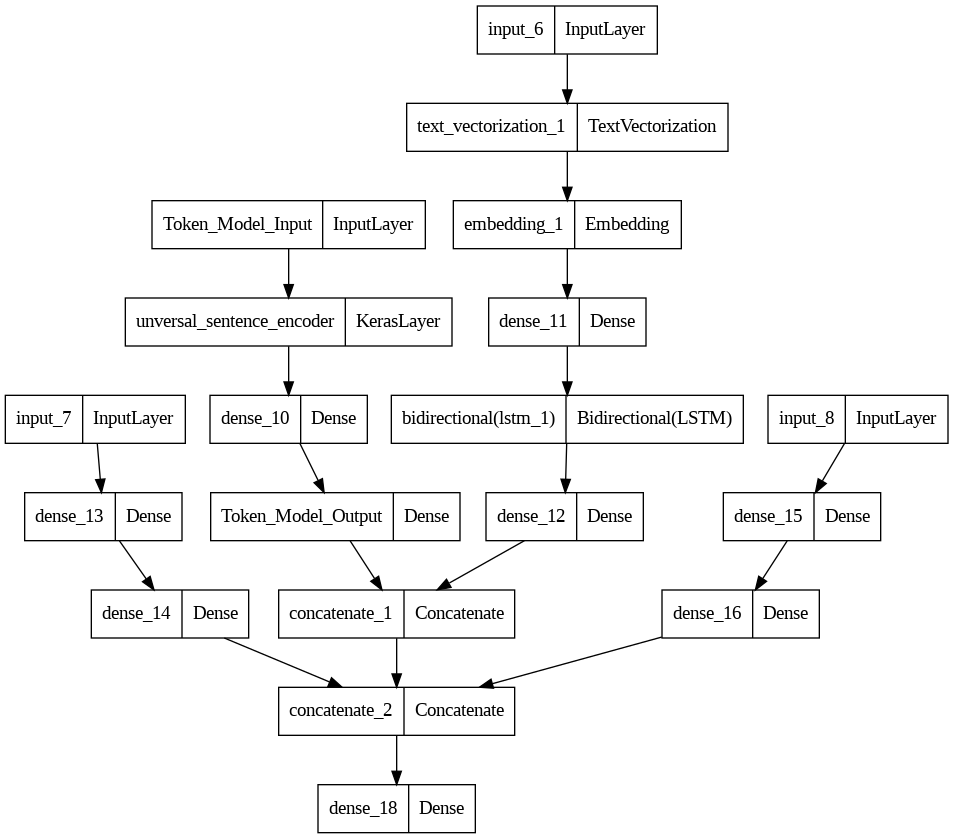

In [77]:
from tensorflow.keras.utils import plot_model

plot_model(model_5)